### TEAMS

In [1]:
import pandas as pd
import numpy as np
import warnings
import funciones_nba_prep
from funciones_nba_prep import *
warnings.filterwarnings('ignore')

In [2]:
data_equipos = pd.read_csv('AllGames_StatsALL.csv')

data_equipos = ordenar_data_equipos(data_equipos)

Ordenamos el Data Frame de manera que sea más fácil trbajar con él.

In [3]:
start_date = '2020-12-22'
end_date = '2023-04-09'
df_22_23 = select_season(start_date, end_date, data_equipos)

Hemos seleccionado las temporadas 20-21, 21-22, 22-23 de las estadisticas de equipos.

In [4]:
lista_equipos = df_22_23['Team'].unique()
columns_to_exclude = ['Team', 'Date1', 'Date', 'H/A', 'Opp', 'Result']
dfs_ponderados = []

for i in lista_equipos:
    team = df_22_23[df_22_23['Team']==i]
    team_pond = stats_acumuladas(team, 5,columns_to_exclude)  
    dfs_ponderados.append(team_pond)

Generamos una lista con los data frames de los equipos con sus estadisticas acumuladas ponderadas.

In [5]:
team_df = pd.concat(dfs_ponderados)
team_df = generate_ID(team_df)
team_df= clean_teamdf(team_df)

Generamos un data frame a partir de la lista anterior, generamos un Game ID y ordenamos y limpiamos el data frame.

### PLAYERS

In [6]:
equipos = ['ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 
                          'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 
                          'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

lista_players_22_23 = Generate_List_Player_Weigth_Stats(equipos)

In [7]:
lista_players_22_23_WC = []
columns_to_exclude = ['Team', 'Date', 'Date1', 'Opp']

for i in lista_players_22_23:
    i_WC = stats_acumuladas(i, 5, columns_to_exclude)
    lista_players_22_23_WC.append(i_WC)

Generamos una lista con las stats acumuladas de P1 y P2.

In [8]:
player_df = pd.concat(lista_players_22_23_WC)

player_df = generate_ID(player_df)

player_df = order_playerdf(player_df)

Generamos un data frame de jugadores a partir de la lista anterior.
Generamos su columna de Game ID
Ordenamos y limpiamos el data frame para trabajar con este y poder unirlo al data frame de equipos.

Ahora que tenemos tanto las estadisticas acumuladas tanto de equipo como de jugadores, vamos a hacer un merge de ambas.

### MERGE

In [9]:
merged_df = pd.merge(team_df, player_df, on=['Game_ID', 'Date', 'Team', 'Opp'], how='outer')

Ahora que tenemos un merge de equipos y jugadores, vamos a separar por la columna H/A y vamos a volver a hacer un merge, para tener todo el partido en una sola fila.

In [10]:
df_sorted = merged_df.copy()
for idx in df_sorted.index:
    if df_sorted.loc[idx, 'H/A'] == '@':
        df_sorted.loc[idx, 'H/A'] = 'Away'
    else:
        df_sorted.loc[idx, 'H/A'] = 'Home'

In [11]:
df_home, df_away = sep_home_away(df_sorted)

Ahora que lo tenemos separados por home y Away, aprovecharemos para generar las rachas de un equipo contra otro.

Por úlitmo uniremos de manera horizontal la columna Home y Away, para así tener los equipos locales a un lado del data frame, y a los equipos visitantes en el otro.

In [12]:
df_rank = df_ranked(df_home, df_away)

In [13]:
df_h_rank, df_a_rank =  sep_home_away(df_rank)
final_df = join_hor_home_away(df_h_rank, df_a_rank)

Solo queda ordenar y renombrar columnas para que el data_set tenga sentido.

In [14]:
final_df = rename_and_order(final_df)

In [15]:
final_df=final_df[(final_df['MP_Home'] != 0) & (final_df['MP_Away'] != 0)]

### IMPORTANTE:

 - Hemos decidido tomar la decisión de que la variable objetivo será el resultado desde la perspectiva del equipo local (Home), por lo que de ahora en adelante (a no ser que cambiemos la decisión, y por tanto el dataset) los modelos que crearemos estarán enfocados en predecir si Home gana o pierde. 

Ahora que tenemos el dataset final, antes de hacer EDA, PCA y demás análisis y preprocesamiento y optimización, vamos a realizar un modelo de prueba para comprobar como rendiría este data frame por sí mismo.

In [16]:
X = final_df._get_numeric_data()
y = final_df['Result']

y = y.apply(lambda x: 'W' if 'W' in str(x) else 'L')
y = pd.DataFrame(y)
y = pd.get_dummies(y, drop_first=True, dtype='float')

In [17]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xtrain, ytrain)

yhat=clf.predict(Xtest)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
round(accuracy_score(ytest, yhat),2)

0.65

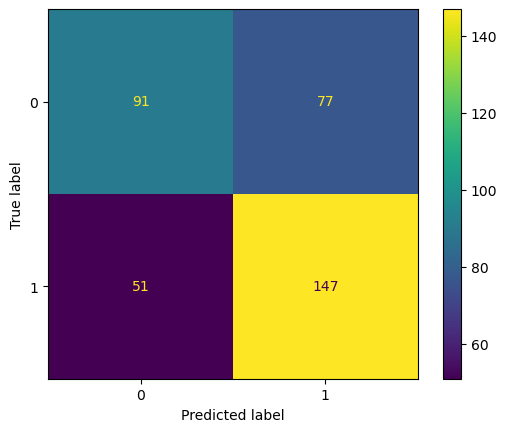

In [18]:
cfm = confusion_matrix(ytest, yhat) # ()
disp = ConfusionMatrixDisplay(cfm)
disp.plot()

Hemos obtenido un accuracy de 0.65, este rendimiento no es del todo malo teniendo en cuenta la complejidad de la predicción y lo prematuro que aún son estos datos.

Una primera obseración de este modelo de prueba es que tiende más a predecir victorias que derrotas, esto seguramente se deba a que estamos prediciendo el resultado del equipo Local, por lo que es normal que tienda en cierta medida hacia la victoria.

In [19]:
#final_df.to_csv('DataFrameForEDA.csv', index=False)